In [ ]:
!pip install tensorflow tensorflow-gpu matplotlib seaborn scikit-learn


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
!pip install -q tensorflow matplotlib seaborn



In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
!git clone https://github.com/Abisheka06/PlantVillage-Dataset.git
%cd PlantVillage-Dataset
!git checkout master


Cloning into 'PlantVillage-Dataset'...
remote: Enumerating objects: 163235, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 163235 (delta 2), reused 1 (delta 0), pack-reused 163229 (from 1)
Receiving objects: 100% (163235/163235), 2.00 GiB | 16.72 MiB/s, done.
Resolving deltas: 100% (101/101), done.
Updating files: 100% (182401/182401), done.


In [ ]:
dataset_path = '/content/PlantVillage-Dataset/raw/color/'

# Split into train/val automatically (80-20 split)
import shutil
from sklearn.model_selection import train_test_split

def split_data(source, train_dir, val_dir, split_ratio=0.8):
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    for class_name in os.listdir(source):
        class_path = os.path.join(source, class_name)
        if os.path.isdir(class_path):
            images = os.listdir(class_path)
            train_imgs, val_imgs = train_test_split(images, train_size=split_ratio, random_state=42)
            os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
            os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

            for img in train_imgs:
                shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
            for img in val_imgs:
                shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_name, img))

split_data(dataset_path, 'train', 'val')


In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    'train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    'val',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 43429 images belonging to 38 classes.
Found 10876 images belonging to 38 classes.


In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # Freeze base

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(train_data.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,595,686 (9.90 MB)

 Trainable params: 337,702 (1.29 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 129s 87ms/step - accuracy: 0.8233 - loss: 0.6601 - val_accuracy: 0.9394 - val_loss: 0.1825
Epoch 2/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 104s 77ms/step - accuracy: 0.9523 - loss: 0.1404 - val_accuracy: 0.9401 - val_loss: 0.1800
Epoch 3/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 106s 78ms/step - accuracy: 0.9658 - loss: 0.1016 - val_accuracy: 0.9572 - val_loss: 0.1318
Epoch 4/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 103s 76ms/step - accuracy: 0.9740 - loss: 0.0764 - val_accuracy: 0.9502 - val_loss: 0.1586
Epoch 5/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 103s 76ms/step - accuracy: 0.9775 - loss: 0.0660 - val_accuracy: 0.9477 - val_loss: 0.1726


In [ ]:
model.save("plant_disease_model.h5")


In [ ]:
from google.colab import files
files.download("plant_disease_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Get predictions
val_data.reset()  # Important to reset before predicting
preds = model.predict(val_data, verbose=1)

# Get predicted class indices
y_pred = np.argmax(preds, axis=1)

# Get true labels
y_true = val_data.classes

# Get class labels
class_labels = list(val_data.class_indices.keys())


340/340 ━━━━━━━━━━━━━━━━━━━━ 24s 70ms/step


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=class_labels))


                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.01      0.01      0.01       126
                                 Apple___Black_rot       0.02      0.02      0.02       125
                          Apple___Cedar_apple_rust       0.00      0.00      0.00        55
                                   Apple___healthy       0.03      0.03      0.03       329
                               Blueberry___healthy       0.05      0.05      0.05       301
          Cherry_(including_sour)___Powdery_mildew       0.02      0.02      0.02       211
                 Cherry_(including_sour)___healthy       0.01      0.01      0.01       171
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.00      0.00      0.00       103
                       Corn_(maize)___Common_rust_       0.03      0.03      0.03       239
               Corn_(maize)___Northern_Leaf_Blight       0.03      0.03      0.

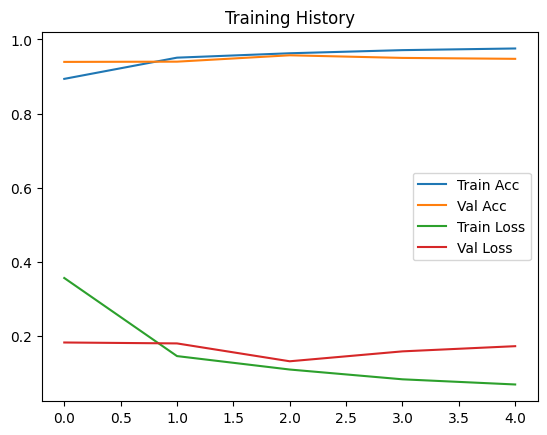

In [ ]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Training History')
plt.show()


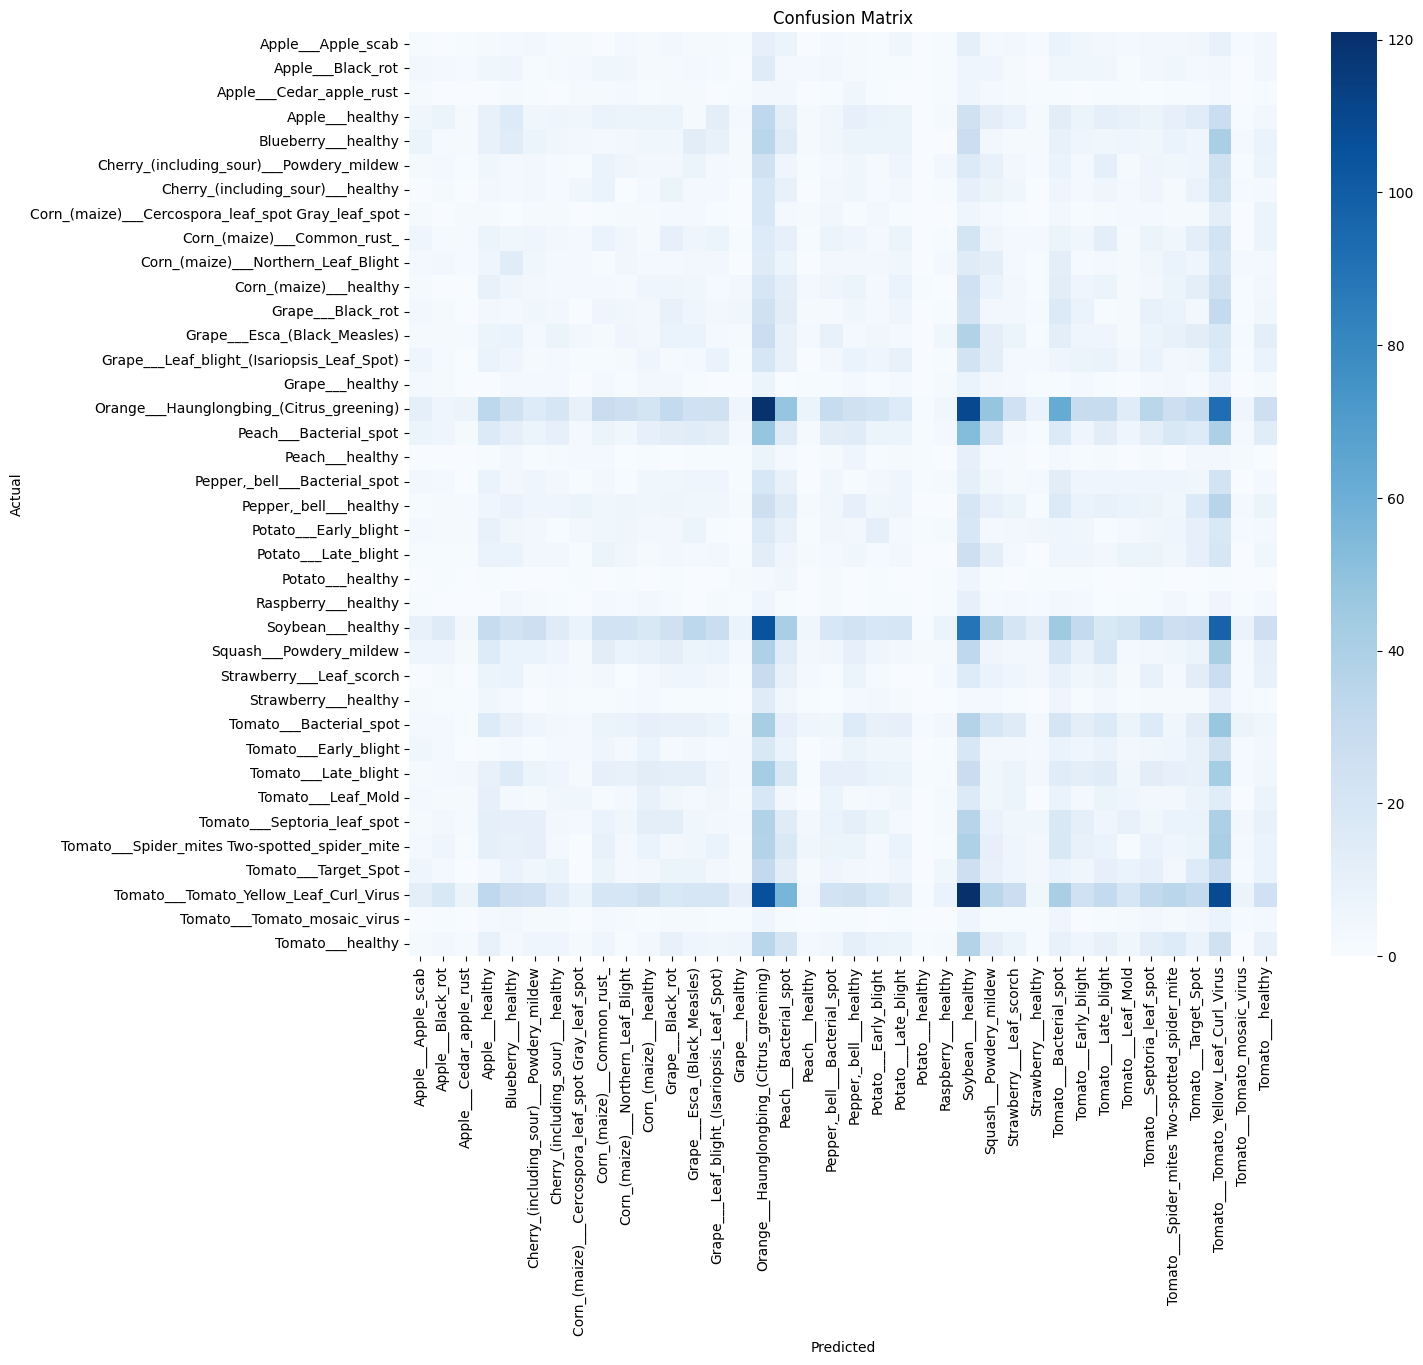

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving 01ad74ce-eb28-42c7-9204-778d17cfd45c___RS_LB 2669.JPG to 01ad74ce-eb28-42c7-9204-778d17cfd45c___RS_LB 2669.JPG


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def predict_image(model, img_path, class_labels, target_size=(224, 224)):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    confidence = np.max(prediction)

    # Show result
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {class_labels[predicted_class]} ({confidence*100:.2f}%)")
    plt.show()

    return class_labels[predicted_class], confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


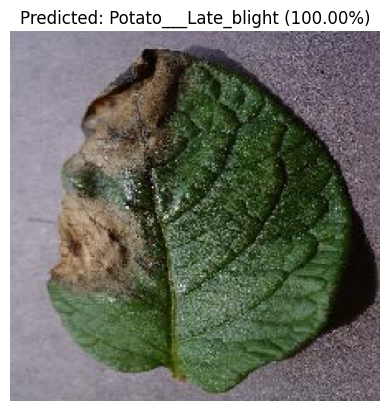

Predicted Class: Potato___Late_blight (Confidence: 1.00)


In [ ]:
import os

# Assuming only one file uploaded
img_path = next(iter(uploaded))
class_labels = list(train_data.class_indices.keys())  # Use your existing data class mapping

# Call the function
predicted_class, confidence = predict_image(model, img_path, class_labels)
print(f"Predicted Class: {predicted_class} (Confidence: {confidence:.2f})")


In [ ]:
# Ensure no shuffle and batch size same as training
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, f1_score

val_data = val_datagen.flow_from_directory(
    'val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Predict
y_pred_probs = model.predict(val_data)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_data.classes
class_labels = list(val_data.class_indices.keys())

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred, target_names=class_labels))

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision (macro):", precision_score(y_true, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_true, y_pred, average='macro'))
print("F1-score (macro):", f1_score(y_true, y_pred, average='macro'))


Found 10876 images belonging to 38 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


340/340 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.89      0.94      0.91       126
                                 Apple___Black_rot       1.00      0.98      0.99       125
                          Apple___Cedar_apple_rust       0.96      0.98      0.97        55
                                   Apple___healthy       0.99      0.98      0.98       329
                               Blueberry___healthy       1.00      0.97      0.98       301
          Cherry_(including_sour)___Powdery_mildew       0.99      1.00      0.99       211
                 Cherry_(including_sour)___healthy       0.97      1.00      0.99       171
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.82      0.82      0.82       103
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       239
               Corn_(maize)___Northe

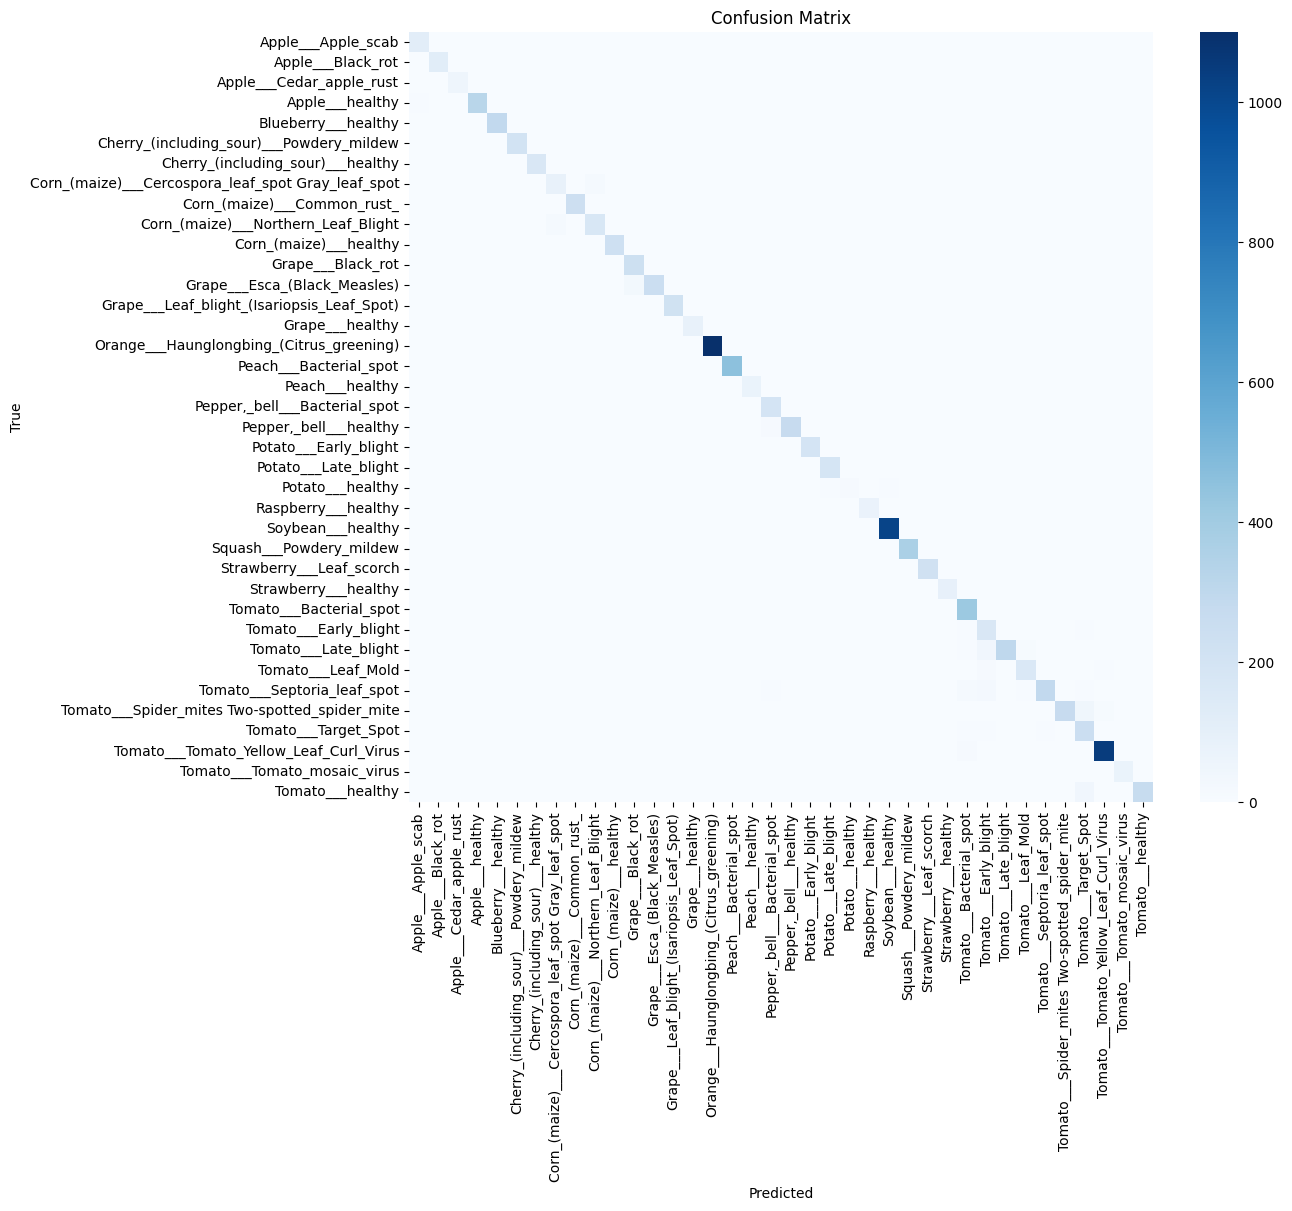

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_true, y_pred)
print("MSE (class index-wise):", mse)


MSE (class index-wise): 2.481335049650607
